In [5]:
import sys
sys.path.insert(1, '../evaluator')

import gc
import itertools
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw
from evaluator import *
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

%matplotlib inline

In [6]:
'''
evaluator.py
IMPORTS:

getTurbLoc(TURB_LOC_file_name)

loadPowerCurve(POWER_CURVE_file_name)

binWindResourceData(WIND_DATA_file_name)

searchSorted(lookup, sample_array)

preProcessing(POWER_CURVE)

getAEP(TURB_DIAM, turb_coords, POWER_CURVE, WIND_INST_FREQ,
       N_WIND_INSTANCES, COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t)
       
checkConstraints(turb_coords, TURB_DIAM)

'''

# Turbine Specifications.
# -**-SHOULD NOT BE MODIFIED-**-
TURB_SPECS    =  {
                     'Name': 'Anon Name',
                     'Vendor': 'Anon Vendor',
                     'Type': 'Anon Type',
                     'Dia (m)': 100,
                     'Rotor Area (m2)': 7853,
                     'Hub Height (m)': 100,
                     'Cut-in Wind Speed (m/s)': 3.5,
                     'Cut-out Wind Speed (m/s)': 25,
                     'Rated Wind Speed (m/s)': 15,
                     'Rated Power (MW)': 3
                 }
TURB_DIAM      =  TURB_SPECS['Dia (m)']
TURB_DIAM       =  TURB_DIAM/2

# Load the power curve
POWER_CURVE   =  loadPowerCurve('./../evaluator/power_curve.csv')

# Pass wind data csv file location to function binWindResourceData.
# Retrieve probabilities of wind instance occurence.
WIND_INST_FREQ =  binWindResourceData('./../evaluator/wind_data/wind_data_2007.csv')

# Doing preprocessing to avoid the same repeating calculations. Record
# the required data for calculations. Do that once. Data are set up (shaped)
# to assist vectorization. Used later in function totalAEP.
N_WIND_INSTANCES, COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t = preProcessing(POWER_CURVE)

# check if there is any constraint is violated before we do anything. 
def evalPrint(turbine_coordinates):
    checkConstraints(turbine_coordinates, TURB_DIAM)
    
    print('[INFO] Calculating AEP')
    AEP = getAEP(TURB_DIAM, turbine_coordinates, POWER_CURVE, WIND_INST_FREQ,
                 N_WIND_INSTANCES, COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t)
    print('[INFO] Power produced : ', "%.12f"%(AEP), 'GWh')
    
    
# TEST VALUES
# Turbine x,y coordinates
TEST_COORDS   =  getTurbLoc(r'./../test_locations.csv')

In [7]:
%%time
# SELF TEST
_ = checkConstraints(TEST_COORDS, TURB_DIAM)
print("--------######---------")
evalPrint(TEST_COORDS)
print()

[SUCCESS] perimeter and proximity constraints - SATISFIED
--------######---------
[SUCCESS] perimeter and proximity constraints - SATISFIED
[INFO] Calculating AEP
[INFO] Power produced :  505.450636596680 GWh

CPU times: user 151 ms, sys: 16.4 ms, total: 167 ms
Wall time: 171 ms


## Classes

In [8]:
class DNA:
    def __init__(self):
        self.fitness = 0
        self.genes, self.state = self.generate_state()
       
    # GENERATE SET OF VALID GENES
    def generate_state(self):
        state = np.zeros((3900, 3900)).astype(np.int8)
        coordinates = np.array([], dtype=np.int64).reshape(0,2)

        count_placed = 0
        while(count_placed < 50):
            free_indices = np.where(state == 0)
            if(len(free_indices[0]) == 0): return -1

            free_indices = np.stack([*free_indices]).transpose()
            free_choice = np.random.choice(len(free_indices))
            index = free_indices[free_choice]

            r, c = draw.circle(index[0], index[1], radius=400, shape=state.shape)
            state[r, c] = 1
            state[index[0],index[1]] = 2

            coordinates = np.concatenate([coordinates, index.reshape(1,2)], axis=0)
            count_placed += 1

        coordinates = coordinates + 50
        return (coordinates.flatten(),  np.pad(state, 50))
        
    # CALC & STORE FITNESS
    def calc_fitness(self):
        if(checkConstraints_F(self.get_tuples(), TURB_DIAM) == -1):
            return 0
        self.fitness = getAEP(TURB_DIAM, self.get_tuples(), POWER_CURVE, WIND_INST_FREQ, 
                              N_WIND_INSTANCES,COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t)
        return self.fitness
    
    # GET DNA AS TUPLE OF COORDINATES
    def get_tuples(self):
        return np.reshape(self.genes, newshape=(50,2))
    
    def __getitem__(self, index):
        print("[ERR] USE d.genes[i]")

In [19]:
class Population:
    def __init__(self, population_size, mutation_rate):
        self.best_DNA = None
        self.best_fitness = 0
        self.generations = 0
        
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        
        self.population = np.array([DNA() for i in range(self.population_size)])
        
#         # MULTITHREADED POPULATION CREATION
#         processes = []
#         with ProcessPoolExecutor(max_workers=4) as executor:
#             for _ in range(self.population_size): 
#                 processes.append(executor.submit(DNA))
#         self.population = np.array([processes[i].result() for i in range(self.population_size)])
    
    # CALC & GET FITNESS
    def calc_fitnesses(self):
        return np.array([self.population[i].calc_fitness() for i in range(self.population_size)])
    
    def get_fitnesses(self):
        return np.array([self.population[i].fitness for i in range(self.population_size)])
    
    ########################
    
    # GET DNAs
    def get_population_DNA(self):
        return np.array([self.population[i].get_DNA() for i in range(self.population_size)])
        
    def __getitem__(self, index):
        print("[ERR] USE p.population[i]")

# Main

In [21]:
%%time
# 1
# SINGLE THREAD
x = Population(5, 0.1)

CPU times: user 38.3 s, sys: 13.8 s, total: 52.1 s
Wall time: 53.1 s


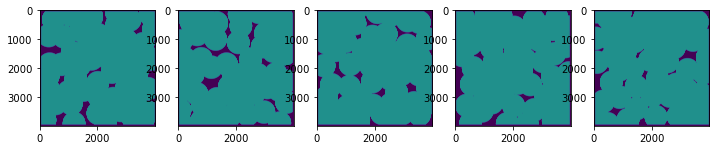

In [22]:
# 1
_, ax = plt.subplots(ncols=5, figsize=(12,4))
for i in range(5):
    ax[i].imshow(x.population[i].state)

In [17]:
%%time
# 2
# MULTI THREAD 
x = Population(5, 0.1)

CPU times: user 113 ms, sys: 211 ms, total: 323 ms
Wall time: 29.3 s


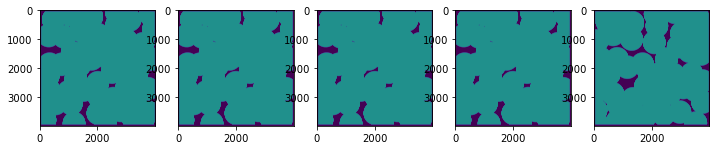

In [18]:
# 2
_, ax = plt.subplots(ncols=5, figsize=(12,4))
for i in range(5):
    ax[i].imshow(x.population[i].state)

In [16]:
display(x.population[0].genes)
display(x.population[0].get_tuples())
x.population[0].genes.shape

array([2803, 2401,  893, 1442, 1092,  843,  718, 2758, 2081, 2385,  402,
        147, 2389,  860, 1889,   80, 2316, 3452, 3206, 1164, 3839, 3190,
       2965, 1543, 2739,  390, 1466,  298, 2974, 3380, 2906, 3808, 1048,
       3788,  389, 2199, 1589, 2990, 3398, 3923, 3620,  710, 2036, 1955,
        613, 3805, 3810, 1371, 3392, 2010,  802, 1963, 2821, 1966,  476,
       3182,  774,  535, 1416, 2130,  156,  627,  233, 1785, 2248,  297,
        111, 1338, 2496, 1637, 1724, 1318, 2559, 2806, 1287, 1316, 3921,
       2283, 1488, 3380, 3867,   54,  578,  965, 3279, 2823, 1055, 3000,
       3102,  688, 1983, 3727,   50, 3441, 1799,  836, 3907, 3873,  234,
       2713])

array([[2803, 2401],
       [ 893, 1442],
       [1092,  843],
       [ 718, 2758],
       [2081, 2385],
       [ 402,  147],
       [2389,  860],
       [1889,   80],
       [2316, 3452],
       [3206, 1164],
       [3839, 3190],
       [2965, 1543],
       [2739,  390],
       [1466,  298],
       [2974, 3380],
       [2906, 3808],
       [1048, 3788],
       [ 389, 2199],
       [1589, 2990],
       [3398, 3923],
       [3620,  710],
       [2036, 1955],
       [ 613, 3805],
       [3810, 1371],
       [3392, 2010],
       [ 802, 1963],
       [2821, 1966],
       [ 476, 3182],
       [ 774,  535],
       [1416, 2130],
       [ 156,  627],
       [ 233, 1785],
       [2248,  297],
       [ 111, 1338],
       [2496, 1637],
       [1724, 1318],
       [2559, 2806],
       [1287, 1316],
       [3921, 2283],
       [1488, 3380],
       [3867,   54],
       [ 578,  965],
       [3279, 2823],
       [1055, 3000],
       [3102,  688],
       [1983, 3727],
       [  50, 3441],
       [1799,

(100,)

In [17]:
x.calc_fitnesses()

array([514.78861267, 512.48519623, 511.57502426])

In [18]:
x.get_fitnesses()

array([514.78861267, 512.48519623, 511.57502426])